# Toxic Phrase Detection — Evaluation Notebook

This notebook is a converted, runnable version of `CrawlData/evaluate_toxic_model.py`.

Outline:
- Environment & versions
- Imports
- Load model and data path checks
- Instantiate detector
- Define test cases
- Run evaluation
- Visualize and save results
- Interactive testing
- Quick assertions / automated checks

Run cells sequentially. If you change `model.py`, use the reload helper in the model-loading cell.

In [1]:
# Section: Environment & versions
import sys
import platform
import importlib

print(f"Python: {sys.version.splitlines()[0]}")
print(f"Platform: {platform.platform()}")
try:
    import pandas as _pd
    print(f"pandas: {_pd.__version__}")
except Exception:
    print("pandas: not installed")
try:
    import matplotlib as _mpl
    print(f"matplotlib: {_mpl.__version__}")
except Exception:
    print("matplotlib: not installed")

# Note: install missing packages in your environment if needed (pip install pandas matplotlib seaborn ipywidgets)

Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-11-10.0.22631-SP0
pandas: 2.3.1
matplotlib: 3.10.3
pandas: 2.3.1
matplotlib: 3.10.3


In [2]:
# Section: Imports
from typing import List, Tuple
import json
import os
from pathlib import Path
import importlib

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# helper to display dataframes if pandas is available
try:
    import pandas as pd
except Exception:
    pd = None

# Try import model (we'll adjust sys.path in the next cell if needed)
try:
    from model import ToxicPhraseDetector
    print('Imported ToxicPhraseDetector from model')
except Exception as e:
    print('Could not import model.ToxicPhraseDetector yet:', e)
    # We'll attempt to fix in the next cell


Imported ToxicPhraseDetector from model


In [4]:
# Section: Load / import model (ToxicPhraseDetector)
# Ensure project root is on sys.path so `import model` works when running the notebook
import sys
from pathlib import Path
import importlib

def find_project_root(start: Path = Path.cwd(), target: str = 'Data/slang.csv', max_up: int = 6) -> Path | None:
    """Search up from start for a directory containing the target file. Returns the directory path or None."""
    p = start.resolve()
    for _ in range(max_up + 1):
        if (p / target).exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return None

try:
    # __file__ exists when executed as script, but NOT in many notebook runtimes
    project_root = Path(__file__).resolve().parent.parent
except NameError:
    # Notebook-safe fallback: search upward from current working directory for Data/slang.csv
    project_root = find_project_root(Path.cwd(), 'Data/slang.csv') or Path.cwd()

print(f"Project root deduced as: {project_root}")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print('Added project root to sys.path')

# Path to slang CSV
slang_csv = project_root / 'Data' / 'slang.csv'
print('Expected slang.csv path:', slang_csv)
print('Exists?', slang_csv.exists())

# Import (with reload helper)
try:
    import model
    importlib.reload(model)
    ToxicPhraseDetector = model.ToxicPhraseDetector
    print('ToxicPhraseDetector loaded from model module')
except Exception as e:
    print('Failed to import model module:', e)
    raise

# Reload function helper
def reload_model():
    importlib.reload(model)
    return model.ToxicPhraseDetector


Project root deduced as: D:\SE400_Seminar_CNPM
Added project root to sys.path
Expected slang.csv path: D:\SE400_Seminar_CNPM\Data\slang.csv
Exists? True
ToxicPhraseDetector loaded from model module


In [5]:
# Section: ToxicModelEvaluator class (copied from script)
from typing import List, Tuple

class ToxicModelEvaluator:
    """Evaluator for the Toxic Phrase Detection Model."""
    
    def __init__(self, detector: ToxicPhraseDetector):
        self.detector = detector
    
    def evaluate(self, test_cases: List[Tuple[str, bool, int]]) -> dict:
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0
        
        correct_counts = 0
        total_expected_phrases = 0
        total_detected_phrases = 0
        
        detailed_results = []
        
        for sentence, expected_toxic, expected_count in test_cases:
            result = self.detector.detect(sentence, return_details=True)
            predicted_toxic = result['is_toxic']
            predicted_count = result['toxic_count']
            
            if expected_toxic and predicted_toxic:
                true_positives += 1
            elif not expected_toxic and predicted_toxic:
                false_positives += 1
            elif not expected_toxic and not predicted_toxic:
                true_negatives += 1
            elif expected_toxic and not predicted_toxic:
                false_negatives += 1
            
            if predicted_count == expected_count:
                correct_counts += 1
            
            total_expected_phrases += expected_count
            total_detected_phrases += predicted_count
            
            detailed_results.append({
                'sentence': sentence,
                'expected_toxic': expected_toxic,
                'predicted_toxic': predicted_toxic,
                'expected_count': expected_count,
                'predicted_count': predicted_count,
                'toxic_phrases': result['toxic_phrases'],
                'correct': expected_toxic == predicted_toxic and expected_count == predicted_count
            })
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (true_positives + true_negatives) / len(test_cases) if test_cases else 0
        count_accuracy = correct_counts / len(test_cases) if test_cases else 0
        
        return {
            'total_test_cases': len(test_cases),
            'true_positives': true_positives,
            'false_positives': false_positives,
            'true_negatives': true_negatives,
            'false_negatives': false_negatives,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'accuracy': accuracy,
            'count_accuracy': count_accuracy,
            'total_expected_phrases': total_expected_phrases,
            'total_detected_phrases': total_detected_phrases,
            'detailed_results': detailed_results
        }

    def print_evaluation_report(self, metrics: dict, show_details: bool = False):
        print("\n" + "="*60)
        print("TOXIC PHRASE DETECTION MODEL - EVALUATION REPORT")
        print("="*60)
        
        print(f"\nTotal Test Cases: {metrics['total_test_cases']}")
        print(f"\nConfusion Matrix:")
        print(f"  True Positives:  {metrics['true_positives']}")
        print(f"  False Positives: {metrics['false_positives']}")
        print(f"  True Negatives:  {metrics['true_negatives']}")
        print(f"  False Negatives: {metrics['false_negatives']}")
        
        print(f"\nPerformance Metrics:")
        print(f"  Accuracy:        {metrics['accuracy']:.2%}")
        print(f"  Precision:       {metrics['precision']:.2%}")
        print(f"  Recall:          {metrics['recall']:.2%}")
        print(f"  F1-Score:        {metrics['f1_score']:.2%}")
        print(f"  Count Accuracy:  {metrics['count_accuracy']:.2%}")
        
        print(f"\nPhrase Detection:")
        print(f"  Expected Phrases:  {metrics['total_expected_phrases']}")
        print(f"  Detected Phrases:  {metrics['total_detected_phrases']}")
        
        if show_details:
            print("\n" + "-"*60)
            print("DETAILED RESULTS:")
            print("-"*60)
            for i, result in enumerate(metrics['detailed_results'], 1):
                status = "✓" if result['correct'] else "✗"
                print(f"\n{i}. {status} {result['sentence']}")
                print(f"   Expected: Toxic={result['expected_toxic']}, Count={result['expected_count']}")
                print(f"   Predicted: Toxic={result['predicted_toxic']}, Count={result['predicted_count']}")
                if result['toxic_phrases']:
                    print(f"   Detected Phrases: {', '.join(result['toxic_phrases'])}")


In [6]:
# Section: Instantiate detector
print('Instantiating ToxicPhraseDetector...')
try:
    detector = ToxicPhraseDetector(slang_csv_path=str(slang_csv), toxic_threshold=3)
    stats = detector.get_statistics()
    print('Detector statistics:')
    if pd is not None:
        display(pd.DataFrame.from_dict(stats, orient='index', columns=['value']))
    else:
        print(stats)
except Exception as e:
    print('Failed to instantiate detector:', e)
    raise

# Create evaluator
evaluator = ToxicModelEvaluator(detector)


Instantiating ToxicPhraseDetector...
Loaded 901 unique toxic phrases from 874 entries (including root words)
Detector statistics:


,value
total_toxic_phrases,901
total_entries,874
by_type,"{'negative': 872, 'neutral': 2}"
avg_toxic_score,2.947368
max_toxic_score,5
min_toxic_score,2


In [7]:
# Section: Define test cases (copy from original script)
# Keep as a variable for reuse
test_cases = [
    ("This is a wonderful day!", False, 0),
    ("I love programming and learning new things", False, 0),
    ("Stop posting ragebait content", True, 1),
    ("This movie is pure brainrot", True, 1),
    ("Downvoted for posting brainrot ragebait", True, 3),
    ("The tankies are spreading ragebait and brainrot content while downvoting everyone", True, 4),
    ("That play was goated!", False, 0),
    ("downvote", True, 1),
    ("RAGEBAIT", True, 1),
    ("Please stop the gooning and focus on work", True, 1),
]

print(f"Loaded {len(test_cases)} test cases")


Loaded 10 test cases


In [8]:
# Section: Run evaluation and compute metrics
metrics = evaluator.evaluate(test_cases)

# Recompute formulas explicitly for transparency
TP = metrics['true_positives']
FP = metrics['false_positives']
TN = metrics['true_negatives']
FN = metrics['false_negatives']
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"TP={TP}, FP={FP}, TN={TN}, FN={FN}")
print(f"Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


TP=7, FP=0, TN=3, FN=0
Precision=1.000, Recall=1.000, F1=1.000


In [9]:
# Section: Display formatted evaluation report
# Pretty print metrics
if pd is not None:
    cm = pd.DataFrame([[TP, FP],[FN, TN]], index=['Actual Positive','Actual Negative'], columns=['Predicted Positive','Predicted Negative'])
    display(cm)
    pr = pd.DataFrame({
        'precision':[precision], 'recall':[recall], 'f1':[f1], 'accuracy':[metrics['accuracy']], 'count_accuracy':[metrics['count_accuracy']]
    })
    display(pr.T)
else:
    print('Metrics:', metrics)

# Optionally show details
show_details = True
if show_details:
    if pd is not None:
        df_details = pd.DataFrame(metrics['detailed_results'])
        display(df_details)
    else:
        for d in metrics['detailed_results']:
            print(d)


,Predicted Positive,Predicted Negative
Actual Positive,7,0
Actual Negative,0,3


,0
precision,1.0
recall,1.0
f1,1.0
accuracy,1.0
count_accuracy,1.0


,sentence,expected_toxic,predicted_toxic,expected_count,predicted_count,toxic_phrases,correct
0,This is a wonderful day!,False,False,0,0,[],True
1,I love programming and learning new things,False,False,0,0,[],True
2,Stop posting ragebait content,True,True,1,1,[ragebait],True
3,This movie is pure brainrot,True,True,1,1,[brainrot],True
4,Downvoted for posting brainrot ragebait,True,True,3,3,"[downvoted, brainrot, ragebait]",True
5,The tankies are spreading ragebait and brainro...,True,True,4,4,"[tankies, brainrot, downvoting, ragebait]",True
6,That play was goated!,False,False,0,0,[],True
7,downvote,True,True,1,1,[downvote],True
8,RAGEBAIT,True,True,1,1,[ragebait],True
9,Please stop the gooning and focus on work,True,True,1,1,[gooning],True


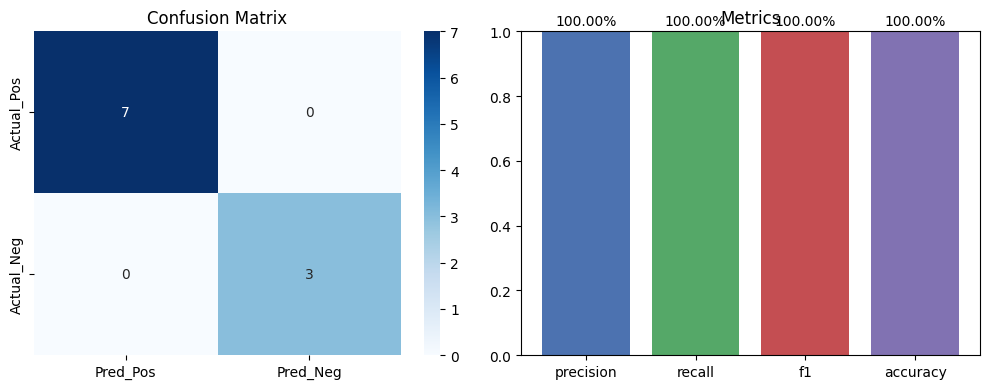

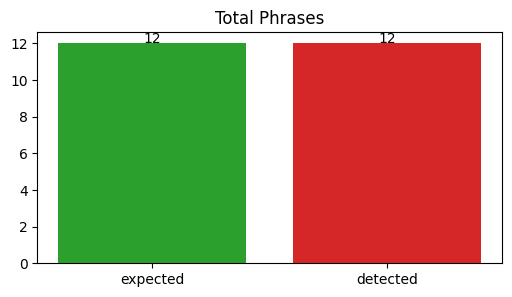

In [10]:
# Section: Visualize metrics
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
conf = [[TP, FP],[FN, TN]]
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred_Pos','Pred_Neg'], yticklabels=['Actual_Pos','Actual_Neg'])
plt.title('Confusion Matrix')

plt.subplot(1,2,2)
metrics_vals = [precision, recall, f1, metrics['accuracy']]
labels = ['precision','recall','f1','accuracy']
plt.bar(labels, metrics_vals, color=['#4c72b0','#55a868','#c44e52','#8172b2'])
plt.ylim(0,1)
for i,v in enumerate(metrics_vals):
    plt.text(i, v+0.02, f"{v:.2%}", ha='center')
plt.title('Metrics')
plt.tight_layout()
plt.show()

# Expected vs Detected phrases
plt.figure(figsize=(6,3))
plt.bar(['expected','detected'], [metrics['total_expected_phrases'], metrics['total_detected_phrases']], color=['#2ca02c','#d62728'])
plt.title('Total Phrases')
for i,v in enumerate([metrics['total_expected_phrases'], metrics['total_detected_phrases']]):
    plt.text(i, v+0.02, str(v), ha='center')
plt.show()


In [12]:
# Section: Interactive testing (simple input)
# Option A: simple input loop (works in notebook cells)

def interactive_test_input():
    print("Enter sentences (blank to stop). Type 'quit' to exit loop")
    while True:
        s = input('Sentence: ').strip()
        if not s or s.lower() in ['quit','exit']:
            break
        res = detector.detect(s, return_details=True)
        print('Is Toxic:', res['is_toxic'])
        print('Toxic Count:', res['toxic_count'])
        if res.get('toxic_phrases'):
            print('Toxic Phrases:', ', '.join(res['toxic_phrases']))
        if res.get('details'):
            for d in res['details']:
                print(f" - {d['phrase']}: score={d.get('toxic_score')} type={d.get('type')}")

# Option B: ipywidgets (if available)
try:
    import ipywidgets as widgets
    from IPython.display import display, Markdown
    text = widgets.Text(placeholder='Type sentence and press Enter')
    out = widgets.Output()

    def on_submit(change):
        with out:
            out.clear_output()
            s = change['new']
            if not s:
                return
            res = detector.detect(s, return_details=True)
            display(Markdown(f"**Is Toxic:** {res['is_toxic']}  \n**Toxic Count:** {res['toxic_count']}"))
            if res.get('toxic_phrases'):
                display(Markdown(f"**Toxic Phrases:** {', '.join(res['toxic_phrases'])}"))
            if res.get('details'):
                display(pd.DataFrame(res['details']) if pd is not None else res['details'])

    text.observe(on_submit, names='value')
    display(text, out)
except Exception as e:
    print('ipywidgets not available or failed to load:', e)
    print('Use interactive_test_input() for a simple input loop')


Text(value='', placeholder='Type sentence and press Enter')

Output()

In [13]:
# Section: Automated checks / quick assertions
# Basic assertions to validate a few behaviors
checks = [
    ("This is a wonderful day!", False, 0),
    ("Stop posting ragebait content", True, 1),
    ("downvote", True, 1),
]
for s, exp_toxic, exp_count in checks:
    r = detector.detect(s, return_details=True)
    assert r['is_toxic'] == exp_toxic, f"Mismatch is_toxic for '{s}'"
    assert r['toxic_count'] == exp_count, f"Mismatch toxic_count for '{s}'"
print('Basic assertions passed')

print('\nNotebook conversion complete. Use cells above to rerun or modify parameters.')


Basic assertions passed

Notebook conversion complete. Use cells above to rerun or modify parameters.
